In [156]:
import numpy as np
import pandas as pd
import sklearn

import os
import re
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Load the data

In [157]:
dir_ = os.path.join("data", "arXivMeta_sample")

file_list = []
for file in os.listdir(dir_):
    file_path = os.path.join(dir_, file)
    file_list.append(file_path)
    print(f"using {file}")
    
all_data = pd.concat([pd.read_csv(file, delimiter='\t', na_values='nan') for file in file_list])

using arXivMeta_all_from_2010-07-02_to_2010-12-31.csv
using arXivMeta_all_from_2010-01-01_to_2010-07-01.csv


## Handle NaNs

In [158]:
# count the NaNs
all_data.isnull().sum()

id            6
authors       0
title         6
abstract      6
categories    6
dtype: int64

In [159]:
# show the NaNs
rows_with_nulls = all_data.isnull().any(axis=1)
print("No. of rows with NaNs: ", sum(rows_with_nulls))
all_data[rows_with_nulls][:3]

No. of rows with NaNs:  6


,id,authors,title,abstract,categories
6789,NaN,[],NaN,NaN,NaN
15875,NaN,[],NaN,NaN,NaN
22299,NaN,[],NaN,NaN,NaN


In [160]:
# All the NaNs are aligned in empty rows.
# We can just drop them.
all_data = all_data.dropna(axis=0, how='any', inplace=False)

## Remove records that start with *This paper has been withdrawn*

In [161]:
withdrawn = all_data.abstract.str.contains("^\s+This paper has been withdrawn")
print(sum(withdrawn))
all_data = all_data[~withdrawn]

105


## Remove suspiciously short abstracts
There are articles where the abstract serves as a comment rather than a summary, e.g. "Discussion on SOME_REFERENCE."

In [162]:
example = all_data[all_data.id == '1001.2975'].abstract.values[0].strip()
print(example)
len(example)

Comment on "Harold Jeffreys's Theory of Probability Revisited"
[arXiv:0804.3173]


80

Let's just decide that abstracts shorter than 160 characters are noice rather than information and remove them.

In [163]:
tresh = 160
print("Removing", sum(all_data.abstract.str.len() < tresh), f"records with abstracts shorter than {tresh}")
all_data = all_data.loc[all_data.abstract.str.len() > tresh]

Removing 1012 records with abstracts shorter than 160


## Check for repeated entries

In [164]:
# Count remaining duplicates in each column separately

print("No. repeated entries in column:")
for column in all_data:
    print( f"{column:<11}", len(all_data) - len(all_data[column].unique()) )

No. repeated entries in column:
id          0
authors     8424
title       51
abstract    46
categories  50382


In [165]:
# As a sidenote, recall how does the *duplicated* function in pandas actually work.
# It flags the duplicates starting from the second repeated entry.

df = pd.DataFrame({'a': [1,1,1], 'b': [2,2,3], 'c': [4,5,6]})
print(df.duplicated(subset=['a','b']))

# To get all repeats use the *keep=False* argument
print(df.duplicated(subset=['a','b'], keep=False))

0    False
1     True
2    False
dtype: bool
0     True
1     True
2    False
dtype: bool


In [166]:
# Back to our data. Remove duplicates where only 'id' is different. (keep=True)

subset = ['authors','title', 'abstract','categories']
duplicates_count = sum(all_data.duplicated(subset=subset))
print(f"Removing {duplicates_count} records that differ at most by 'id'.")
all_data = all_data.drop_duplicates(subset=subset)

Removing 13 records that differ at most by 'id'.


In [167]:
# Now, there are records where authors, title and abstract are the same but categories are different.
subset=['authors','title', 'abstract']
wrong_cats = all_data[all_data.duplicated(subset=subset, keep=False)]

# One may examine them out of curiosity
display(pd.concat(g for _, g in wrong_cats.groupby(subset) ))

# We will just ignore them all, since they are ambigous for our purpose and there's few of them. (keep=False)
print(f"Removing {len(wrong_cats)} duplicates with ambigous 'categories'.")
all_data = all_data.drop_duplicates(subset=subset, keep=False)

,id,authors,title,abstract,categories
10294,1003.4183,['Jérôme Lelong'],Asymptotic normality of randomly truncated sto...,We study the convergence rate of randomly tr...,math.PR
20317,1003.4920,['Jérôme Lelong'],Asymptotic normality of randomly truncated sto...,We study the convergence rate of randomly tr...,math.PR math.OC
21133,1004.2637,"['Karine Altisen', 'Yanhong Liu', 'Matthieu Moy']",Performance Evaluation of Components Using a G...,To analyze complex and heterogeneous real-ti...,cs.PF
25108,1006.5095,"['Karine Altisen', 'Yanhong Liu', 'Matthieu Moy']",Performance Evaluation of Components Using a G...,To analyze complex and heterogeneous real-ti...,cs.PF cs.LO
2764,1003.3566,['M. Ibrahim Moussa'],An Algorithm for Odd Graceful Labeling of the ...,"In 1991, Gnanajothi [4] proved that the path...",cs.NI
21502,1004.3745,['M. Ibrahim Moussa'],An Algorithm for Odd Graceful Labeling of the ...,"In 1991, Gnanajothi [4] proved that the path...",cs.IT cs.NI math.IT


Removing 6 duplicates with ambigous 'categories'.


In [168]:
# It's less clear what to do when different authors have articles with identical titles, abstracts and categories.

# They may actually be originating from genuinly different articles,
# but in such case the repeated abstract is probably not very informative
# in the first place, e.g. ["1002.4494", "1002.4496", "1002.4509"].
# They may also be a product of a single project, e.g. ["1008.4993", "1008.2567"]

subset=['title', 'abstract', 'categories']
wrong_auth = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in wrong_auth.groupby(subset) ))

# We will keep one copy of such duplicates
print(f"Something wrong with authors above. Keep one of each copy.")
all_data = all_data.drop_duplicates(subset=subset)

,id,authors,title,abstract,categories
8872,1002.4494,['Ying Wei'],"Discussion of ""Multivariate quantiles and mult...","Discussion of ""Multivariate quantiles and mu...",math.ST stat.TH
8873,1002.4496,"['Robert Serfling', 'Yijun Zuo']","Discussion of ""Multivariate quantiles and mult...","Discussion of ""Multivariate quantiles and mu...",math.ST stat.TH
8879,1002.4509,"['Linglong Kong', 'Ivan Mizera']","Discussion of ""Multivariate quantiles and mult...","Discussion of ""Multivariate quantiles and mu...",math.ST stat.TH
7347,1008.4993,"['K. Sakai', 'T. Kawasaki', 'H. Aihara', 'K. A...",Search for CP violating charge asymmetry in B^...,We present the result of a search for charge...,hep-ex
15809,1008.2567,"['K. Sakai', 'T. Kawasaki', 'H. Aihara', 'K. A...",Search for CP violating charge asymmetry in B^...,We present the result of a search for charge...,hep-ex


Something wrong with authors above. Keep one of each copy.


In [169]:
# It also happens that a typo in the title gets corrected or the phrasing in the title is refomulated.
# When authors, abstract and categories match, but titles differ - we retain one record in the series of duplicates.

subset=['authors', 'abstract', 'categories']
wrong_title = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in wrong_title.groupby(subset) ))

print(f"Something wrong with titles above. Keep one of each copy.")
all_data = all_data.drop_duplicates(subset=subset)

,id,authors,title,abstract,categories
10272,1003.4121,['Armel Andami Ovono'],Asymptotic behaviour for a diffusion equation ...,In this paper we study the asymptotic behavi...,math.AP
21969,1004.5297,['Armel Andami Ovono'],Asymptotic behaviour for a diffusion equation ...,In this paper we study the asymptotic behavi...,math.AP
7544,1002.0416,"['Dakshina Ranjan Kisku', 'Phalguni Gupta', 'J...",Fusion of Multiple Matchers using SVM for Offl...,This paper uses Support Vector Machines (SVM...,cs.CV cs.LG
10719,1003.5865,"['Dakshina Ranjan Kisku', 'Phalguni Gupta', 'J...",Offline Signature Identification by Fusion of ...,This paper uses Support Vector Machines (SVM...,cs.CV cs.LG
21457,1012.1691,['François Dubois'],Dual Raviart-Thomas mixed finite elements,For an elliptic problem with two space dimen...,math.NA
21468,1012.1734,['François Dubois'],Petrov-Galerkin Finite Volumes,For an elliptic problem with two space dimen...,math.NA
3837,1006.3371,['Kamaljit I. Lakhtaria'],Enhancing QoS and QoE in IMS Enabled Next Gene...,"Managing network complexity, accommodating g...",cs.NI
6398,1008.1848,['Kamaljit I. Lakhtaria'],Enhancing QOS and QOE in IMS enabled next gene...,"Managing network complexity, accommodating g...",cs.NI
13028,hep-th/9911044,"['N. Mebarki', 'A. Maireche']",Quantum Nonsymmetric Gravity and The Superfibe...,Withdrawn by arXiv administration because au...,hep-th
13029,hep-th/9911048,"['N. Mebarki', 'A. Maireche']",Quantum Nonsymmetric Gravity Geometric Commuta...,Withdrawn by arXiv administration because au...,hep-th


Something wrong with titles above. Keep one of each copy.


In [170]:
# Similarly when authors, title and categories match in the duplicates but abstracts differ,
# it is probably because of honest corrections done to a genuine article.

subset=['authors', 'title', 'categories']
wrong_abstract = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in wrong_abstract.groupby(subset) ))

# Again we retain one copy.
print(f"Something wrong with abstracts above. Keep one of each copy.")
all_data = all_data.drop_duplicates(subset=subset)

,id,authors,title,abstract,categories
24580,1006.3202,['Alexander Dietz'],Searches for inspiral gravitational waves asso...,This brief report describes the search for g...,gr-qc astro-ph.HE
24628,1006.3393,['Alexander Dietz'],Searches for inspiral gravitational waves asso...,"Mergers of two compact objects, like two neu...",gr-qc astro-ph.HE
26831,hep-ex/9801019,"['CDF Collaboration', 'F. Abe et al']",Searches for New Physics in Diphoton Events in...,We have searched for anomalous production of...,hep-ex hep-ph
26850,hep-ex/9806034,"['CDF Collaboration', 'F. Abe et al']",Searches for New Physics in Diphoton Events in...,We present a detailed description of a searc...,hep-ex hep-ph
8337,1009.2974,['Ewelina Kamińska'],Analysis of semidiscretization of the compress...,The objective of this work is to present the...,math.CA
8382,1009.3141,['Ewelina Kamińska'],Analysis of semidiscretization of the compress...,The objective of this work is to present the...,math.CA
3596,1005.5615,"['François Mallet', 'Florian R. Ong', 'Agustin...",Single-shot qubit readout in circuit Quantum E...,The future development of quantum informatio...,quant-ph cond-mat.supr-con
22932,1005.3436,"['François Mallet', 'Florian R. Ong', 'Agustin...",Single-shot qubit readout in circuit Quantum E...,The future development of quantum informatio...,quant-ph cond-mat.supr-con
3942,1006.4653,['Givon Zirkind'],Using Repeating Decimals As An Alternative To ...,This article is meant to provide an addition...,cs.CR
4030,1006.5922,['Givon Zirkind'],Using Repeating Decimals As An Alternative To ...,This article is meant to provide an addition...,cs.CR


Something wrong with abstracts above. Keep one of each copy.


In [171]:
# We are chiefly interested in abstracts and categories. So let's see what duplicates in those we are left with.
# It's not obvious what happened there, perhaps all these people are dirty plagiarists who did not bother to change the abstracts.
# More likely the author had mercifully found himself co-authors, had altered the title and resubmitted the article
# Retain one of each copy.

subset=['abstract', 'categories']
something_wrong = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in something_wrong.groupby(subset) ))

print(f"Something wrong with authors and titles above. Keep one of each copy.")
all_data = all_data.drop_duplicates(subset=subset)

,id,authors,title,abstract,categories
10583,0804.4147,['G. Altarelli'],Status of the Standard Model at the LHC Start,I present a concise review of where we stand...,hep-ph
9021,1002.4957,['Guido Altarelli'],Particle Physics in the LHC Era and beyond,I present a concise review of where we stand...,hep-ph
10034,1003.3382,"['Kazem Haghnejad Azar', 'Abdolhamid Riazi']",Arens Regularity And The Topological Centers O...,"In this article, for Banach left and right m...",math.FA
21069,1004.2386,['Kazem Haghnejad Azar'],The Topological Centers Of Module Actions,"In this article, for Banach left and right m...",math.FA
19363,1011.1362,"['Madad Khan', 'Naveed Ahmad']",Characterizations of {\Gamma}-AG^{**}-groupoid...,In this paper we have discusses {\Gamma}-lef...,math.GR
21520,1012.1923,"['Madad Khan', 'Naveed Ahmad', 'Inayatur Rehman']",Characterizations of gamma-AG^{**}-groupoids b...,In this paper we have discusses {\Gamma}-lef...,math.GR
6135,1001.1921,"['Frédéric Planchet', 'Marc Juillard']",Mesure de l'incertitude tendancielle sur la mo...,The aim of this paper is to propose a realis...,q-fin.GN q-fin.RM
6136,1001.1922,"['Frédéric Planchet', 'Laurent Faucillon', 'Ma...",Etude du risque syst\'ematique de mortalit\'e,The aim of this paper is to propose a realis...,q-fin.GN q-fin.RM
21081,1012.0130,"['Mincheol Han', 'Maria Grazia Pia', 'Hee Seo'...",Physics Data Management Tools for Monte Carlo ...,The development of a package for the managem...,physics.comp-ph
21963,1012.3292,"['Mincheol Han', 'Chan-Hyeung Kim', 'Lorenzo M...",Physics data management tools: computational e...,The development of a package for the managem...,physics.comp-ph


Something wrong with authors and titles above. Keep one of each copy.


In [172]:
# Now, let's again count remaining duplicates in each column separately
# We will not bother to remove them

print("No. repeated entries in column:")
for column in all_data:
    print( f"{column:<11}", len(all_data) - len(all_data[column].unique()) )

No. repeated entries in column:
id          0
authors     8383
title       16
abstract    12
categories  50331


---

In [173]:
# Read in categories described in the *arXiv_metadata_harvester.ipynb*

from my_utilities import read_dict

physics_genres = read_dict("physics_genres.txt")
print(physics_genres)

top_cats = read_dict("top_cats.txt")
top_cats

{'astro-ph': 'Astrophysics', 'cond-mat': 'Condensed Matter', 'gr-qc': 'General Relativity and Quantum Cosmology', 'hep-ex': 'High Energy Physics - Experiment', 'hep-lat': 'High Energy Physics - Lattice', 'hep-ph': 'High Energy Physics - Phenomenology', 'hep-th': 'High Energy Physics - Theory', 'math-ph': 'Mathematical Physics', 'nlin': 'Nonlinear Sciences', 'nucl-ex': 'Nuclear Experiment', 'nucl-th': 'Nuclear Theory', 'physics': 'Physics (Other)', 'quant-ph': 'Quantum Physics'}


{'cs': 'Computer Science',
 'math': 'Mathematics',
 'physics': 'Physics',
 'q-bio': 'Quantitative Biology',
 'q-fin': 'Quantitative Finance',
 'stat': 'Statistics'}

In [175]:
# Extract first word from the list of categories in all_data data-frame.
# Take only the term up to a dot from that word

# Although it is not visibly indicated in the dataset,
# these first categories are the primary_categories of each article.
# We want to map them into one of our six top_categories (see top_cats dictionary)

#top_categories = all_data.categories.str.extract(r'([\w\-]+)[\.\s]*', expand=False)
primary_categories = all_data.categories.str.split().str[0]
all_data['prim_cat'] = primary_categories
all_data[:3]

,id,authors,title,abstract,categories,prim_cat
0,0704.0204,"['Marco G. Pala', 'Michele Governale', 'Jürgen...",Non-Equilibrium Josephson and Andreev Current ...,We present a theory of transport through int...,cond-mat.supr-con cond-mat.mes-hall,cond-mat.supr-con
1,0704.0217,"['Wiroonsak Santipach', 'Michael L. Honig']",Capacity of a Multiple-Antenna Fading Channel ...,Given a multiple-input multiple-output (MIMO...,cs.IT math.IT,cs.IT
2,0704.0923,['Steven J. Miller'],When the Cramer-Rao Inequality provides no inf...,We investigate a one-parameter family of pro...,math.ST stat.TH,math.ST


In [176]:
# Let's have a look at all possible categories

categories_set = set()
for cats in all_data.categories.str.split():
    categories_set.update(set(cats))
categories_set

{'acc-phys',
 'adap-org',
 'alg-geom',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'comp-gas',
 'cond-mat',
 'cond-mat.dis-nn',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.quant-gas',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'dg-ga',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'math-ph',
 'math.AC',
 'math.AG',
 'math.AP',
 'math.AT',
 'math.CA',
 'math.CO',
 'math.CT',
 'math.CV',
 'math.DG',
 'math.DS',

In [210]:
# extract the first level categorization, e.g. cond-mat.quant-gas -> cond-mat
# str1='cond-mat.dis-nn'
# str2='bayes-an'

semitop_categories = set()

pattern = re.compile(r'([\w\-]+)')
for cat in categories_set:
    match = pattern.match(cat).group(1)
    semitop_categories.update([match])
    
semitop_categories = pd.Series(list(semitop_categories))
semitop_categories[:3]

0    solv-int
1      hep-ex
2        stat
dtype: object

In [102]:
# try to create map from semitop_categories to top_cats using physic_genres

mapping = {}
for top_cat in top_cats:
    mapping[top_cat] = top_cat
for genre in physics_genres:
    mapping[genre] = "phys"
mapping

{'cs': 'cs',
 'math': 'math',
 'physics': 'phys',
 'q-bio': 'q-bio',
 'q-fin': 'q-fin',
 'stat': 'stat',
 'astro-ph': 'phys',
 'cond-mat': 'phys',
 'gr-qc': 'phys',
 'hep-ex': 'phys',
 'hep-lat': 'phys',
 'hep-ph': 'phys',
 'hep-th': 'phys',
 'math-ph': 'phys',
 'nlin': 'phys',
 'nucl-ex': 'phys',
 'nucl-th': 'phys',
 'quant-ph': 'phys'}

In [212]:
# let's see which subcategories will not be mapped by the 'mapping' dict

semitop_categories[pd.isnull(semitop_categories.map(mapping))]

0     solv-int
3     patt-sol
4     bayes-an
5     alg-geom
7     comp-gas
10    funct-an
14    acc-phys
16    supr-con
17    adap-org
18       q-alg
21    chao-dyn
25     atom-ph
30       dg-ga
dtype: object

In [218]:
# we'll have to google those and assign them by hand
clean_up_mask = {}
clean_up_mask['acc-phys'] = 'physics'
clean_up_mask['adap-org'] = 'nlin.AO'
clean_up_mask['alg-geom'] = 'math.AG'
clean_up_mask['atom-ph'] = 'physics'
clean_up_mask['chao-dyn'] = 'nlin.CD'
clean_up_mask['comp-gas'] = 'nlin.CG'
clean_up_mask['dg-ga'] = 'math.DG'
clean_up_mask['funct-an'] = 'math.FA'
clean_up_mask['q-alg'] = 'math.QA'
clean_up_mask['solv-int'] = 'nlin.SI'
clean_up_mask['patt-sol'] = 'nlin.PS'
clean_up_mask['bayes-an'] = 'physics.data-an'
clean_up_mask['supr-con'] = 'cond-mat.supr-con'

def clean_up(cat):
    if cat in clean_up_mask:
        return clean_up_mask[cat]
    else:
        return cat

semitop_categories.map(clean_up).sort_values()

8              astro-ph
13             cond-mat
16    cond-mat.supr-con
11                   cs
12                gr-qc
1                hep-ex
20              hep-lat
23               hep-ph
6                hep-th
15                 math
9               math-ph
5               math.AG
30              math.DG
10              math.FA
18              math.QA
27                 nlin
17              nlin.AO
21              nlin.CD
7               nlin.CG
3               nlin.PS
0               nlin.SI
28              nucl-ex
24              nucl-th
19              physics
25              physics
14              physics
4       physics.data-an
29                q-bio
22                q-fin
26             quant-ph
2                  stat
dtype: object

,id,authors,title,abstract,categories,prim_cat
0,0704.0204,"['Marco G. Pala', 'Michele Governale', 'Jürgen...",Non-Equilibrium Josephson and Andreev Current ...,We present a theory of transport through int...,cond-mat.supr-con cond-mat.mes-hall,cond-mat.supr-con
1,0704.0217,"['Wiroonsak Santipach', 'Michael L. Honig']",Capacity of a Multiple-Antenna Fading Channel ...,Given a multiple-input multiple-output (MIMO...,cs.IT math.IT,cs.IT
2,0704.0923,['Steven J. Miller'],When the Cramer-Rao Inequality provides no inf...,We investigate a one-parameter family of pro...,math.ST stat.TH,math.ST


In [103]:
# Add new column to our data-frame with primary categories ('prim_cat')
# mapped from first elements of 'categories'

all_data['prim_cat'] = top_categories.map(mapping)
all_data[:3]

,id,authors,title,abstract,categories,prim_cat
0,0704.0204,"['Marco G. Pala', 'Michele Governale', 'Jürgen...",Non-Equilibrium Josephson and Andreev Current ...,We present a theory of transport through int...,cond-mat.supr-con cond-mat.mes-hall,phys
1,0704.0217,"['Wiroonsak Santipach', 'Michael L. Honig']",Capacity of a Multiple-Antenna Fading Channel ...,Given a multiple-input multiple-output (MIMO...,cs.IT math.IT,cs
2,0704.0923,['Steven J. Miller'],When the Cramer-Rao Inequality provides no inf...,We investigate a one-parameter family of pro...,math.ST stat.TH,math


## ...

In [149]:
# Our mapping from 'categories' to 'prim_cat' failed is some instances.
# That's because some older pre-prints seem have some semi-descriptive name prepended to the list of categories
# E.g. 

top_categories[pd.isnull(all_data.prim_cat)].

9288      atom-ph
9488     funct-an
9859        q-alg
9860        q-alg
9861        q-alg
22802    acc-phys
22803    alg-geom
23684     atom-ph
23685    chao-dyn
23686    chao-dyn
23687    chao-dyn
23688    chao-dyn
23689    chao-dyn
23913       dg-ga
28088       q-alg
28089       q-alg
28090       q-alg
28159    solv-int
28160    solv-int
10813    adap-org
11000    chao-dyn
11001    chao-dyn
11002    chao-dyn
11003    comp-gas
25364    alg-geom
25365    alg-geom
25366    alg-geom
25367    alg-geom
25369    alg-geom
25370    alg-geom
25371    alg-geom
25372    alg-geom
25771    chao-dyn
25932       dg-ga
25933       dg-ga
29091    solv-int
29092    solv-int
Name: categories, dtype: object

In [134]:
all_data[[type(item) != str for item in top_categories.map(mapping)]]

,id,authors,title,abstract,categories,prim_cat
9288,atom-ph/9509005,"['Abir Bandyopadhyay', 'Jagdish Rai']",Squeezing in the interaction of radiation with...,We propose a simple experimental procedure t...,atom-ph physics.atom-ph physics.optics quant-ph,NaN
9488,funct-an/9408004,['Michael Frank'],Hilbert C*-modules over monotone complete C*-a...,The aim of the present paper is to describe ...,funct-an math.OA,NaN
9859,q-alg/9604003,['J. F. van Diejen'],Commuting difference operators with applicatio...,Elementary properties of the Koornwinder-Mac...,q-alg math.QA,NaN
9860,q-alg/9604004,['Jan F. van Diejen'],Properties of some families of hypergeometric ...,Limiting cases are studied of the Koornwinde...,q-alg math.CA math.QA,NaN
9861,q-alg/9607003,"['Jan F. van Diejen', 'Jasper V. Stokman']",Multivariable q-Racah polynomials,The Koornwinder-Macdonald multivariable gene...,q-alg math.CA math.QA,NaN
22802,acc-phys/9510002,['Sergey S. Kurennoy'],Polarizabilities of an Annular Cut in the Wall...,The electric and magnetic polarizabilities o...,acc-phys physics.acc-ph,NaN
22803,alg-geom/9703030,"['Daniel C. Cohen', 'Alexander I. Suciu']",Alexander Invariants of Complex Hyperplane Arr...,Let A be an arrangement of complex hyperplan...,alg-geom math.AG,NaN
23684,atom-ph/9510002,"['Abir Bandyopadhyay', 'Jagdish Rai']",Quantum uncertainties in coupled harmonic osci...,In this paper we analyze the quantum uncerta...,atom-ph physics.atom-ph physics.optics quant-ph,NaN
23685,chao-dyn/9501009,"['N. Berglund', 'H. Kunz']",Integrability and Ergodicity of Classical Bill...,"We consider classical billiards in plane, co...",chao-dyn nlin.CD nlin.SI solv-int,NaN
23686,chao-dyn/9604018,"['N. Berglund', 'Alex Hansen', 'E. H. Hauge', ...",Can a local repulsive potential trap an electron?,We study the classical dynamics of a charged...,chao-dyn cond-mat nlin.CD,NaN


In [146]:
old_format = all_data.id.str.match(r'[\w\-]+/\d{7}')
cats_to_remove = all_data.id.str.extract(r'([\w\-]+)/')
all_data[old_format].categories

9281                               astro-ph hep-ex nucl-ex
9282                                              astro-ph
9283                                astro-ph hep-ph hep-th
9284                                              astro-ph
9285                                              astro-ph
9286                          astro-ph gr-qc hep-ph hep-th
9287                                       astro-ph hep-ph
9288       atom-ph physics.atom-ph physics.optics quant-ph
9289     cond-mat.mes-hall cond-mat.mtrl-sci cond-mat.s...
9290     cond-mat.mtrl-sci cond-mat.soft cond-mat.stat-...
9291                                              cond-mat
9292                                    cond-mat.stat-mech
9293                                    cond-mat.stat-mech
9294                                       cond-mat.str-el
9295                                     cond-mat.mes-hall
9296                                              cond-mat
9297     cond-mat.mes-hall cond-mat.mtrl-sci cond-mat.s.

In [104]:
def show_cats(df):
    
    cats = df.prim_cat.unique()
    record_counts = []
    
    for cat in cats:
        count = sum(df.prim_cat == cat)
        record_counts.append( [cat, count/1000] )
    
    record_counts = sorted(record_counts, key = lambda x: x[1], reverse=True)
    
    record_counts = np.array(record_counts)
    record_counts_df = pd.DataFrame({'categories': record_counts[:,0], '1000 papers': record_counts[:,1]}).set_index('categories')
    display(record_counts_df)
    record_counts_df.astype('float').plot.bar()
    plt.show()

,1000 papers
categories,
phys,37.024
math,12.466
cs,5.156
q-bio,0.535
stat,0.506
q-fin,0.341
nan,0.0


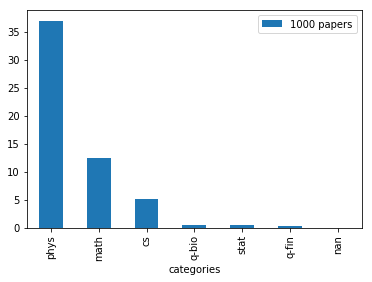

In [105]:
show_cats(all_data)

---

In [212]:
duplicated_abstracts[duplicated_abstracts.duplicated(subset='title')]

,id,authors,title,abstract,categories
6544,1001.2985,['Arnold Zellner'],"Comment on ""Harold Jeffreys's Theory of Probab...","Comment on ""Harold Jeffreys's Theory of Prob...",stat.ME
6576,1001.3073,['Dennis Lindley'],"Comment on ""Harold Jeffreys's Theory of Probab...","Comment on ""Harold Jeffreys's Theory of Prob...",stat.ME
8879,1002.4509,"['Linglong Kong', 'Ivan Mizera']","Discussion of ""Multivariate quantiles and mult...","Discussion of ""Multivariate quantiles and mu...",math.ST stat.TH
16952,1010.0836,"['Arthur Gretton', 'Kenji Fukumizu', 'Bharath ...",Discussion of: Brownian distance covariance,"Discussion on ""Brownian distance covariance""...",stat.AP
16954,1010.0839,['Christopher R. Genovese'],Discussion of: Brownian distance covariance,"Discussion on ""Brownian distance covariance""...",stat.AP


In [133]:
duplicated_abstracts[:].groupby('abstract')['title'].apply(list)[:1]

abstract
  After two decades of repository development, some conclusions may be drawn as\nto which type of repository and what kind of service best supports digital\nscholarly communication, and thus the production of new knowledge. Four types\nof publication repository may be distinguished, namely the subject-based\nrepository, research repository, national repository system and institutional\nrepository. Two important shifts in the role of repositories may be noted. With\nregard to content, a well-defined and high quality corpus is essential. This\nimplies that repository services are likely to be most successful when\nconstructed with the user and reader uppermost in mind. With regard to service,\nhigh value to specific scholarly communities is essential. This implies that\nrepositories are likely to be most useful to scholars when they offer dedicated\nservices supporting the production of new knowledge. Along these lines,\nchallenges and barriers to repository development may be i

In [124]:
nonan_all_data[nonan_all_data.duplicated(subset='title')].groupby('title').apply(list)

title
A New Email Retrieval Ranking Approach                                                                                                                                                                             [id, authors, title, abstract, categories]
A Parsing Scheme for Finding the Design Pattern and Reducing the\n  Development Cost of Reusable Object Oriented Software                                                                                          [id, authors, title, abstract, categories]
A fast and robust patient specific Finite Element mesh registration\n  technique: application to 60 clinical cases                                                                                                 [id, authors, title, abstract, categories]
A note on precised Hardy inequalities on Carnot groups and Riemannian\n  manifolds                                                                                                                                 [id, authors, title, 

In [129]:
df = pd.DataFrame( {'a':['A','A','B','B','B','C'], 'b':[1,2,5,5,4,6]})
df

,a,b
0,A,1
1,A,2
2,B,5
3,B,5
4,B,4
5,C,6


In [135]:
df.groupby('a')['b'].apply(list)

a
A       [1, 2]
B    [5, 5, 4]
C          [6]
Name: b, dtype: object

In [79]:
# franction of records with more than one category
sum( len(str(category).split())>1 for category in all_data.categories ) / len(all_data)

0.4091766514130017

In [74]:
sum(mygen)

23427

In [59]:
np.isnan('nan')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

---

### old

In [7]:
# load the csv's obtained with 'arXiv_metadata_harvester.ipynb'

#dir_ = os.path.join("data", "arXivMeta_completed")
#dir_ = os.path.join("data", "arXivMeta_example_bak")

dfs = {}

# create dict of file-lists dfs = {'cs': [file1, ...], 'math': ..., etc.}
for file in os.listdir(dir_):
    info = re.search(r'arXivMeta_(.+?)_(.+?)\.(\w+?)', file)
    cat = info.group(1)
    date = info.group(2)
    print(f'{cat:>9}: {date}')
    
    file_path = os.path.join(dir_, file)
    
    if cat not in dfs:
        dfs[cat] = [file_path]
    else:
        dfs[cat].append(file_path)

# create dict of data_frames dfs = {'cs': pd.DataFrame(), 'math': ..., etc.}       
def getdf(file_list):
    cat_dfs = [pd.read_csv(file, delimiter='\t') for file in file_list]
    return pd.concat(cat_dfs)

dfs = {cat: getdf(cat_files) for (cat, cat_files) in dfs.items()}

       cs: from_2016-01-01_to_2016-12-31
     math: from_2016-01-01_to_2016-07-01
     math: from_2016-07-02_to_2016-12-31
  physics: from_2016-01-01_to_2016-05-01
  physics: from_2016-05-02_to_2016-09-01
  physics: from_2016-09-02_to_2016-12-31
    q-bio: from_2016-01-01_to_2016-12-31
    q-fin: from_2016-01-01_to_2016-12-31
     stat: from_2016-01-01_to_2016-12-31


---

# Explore and select the data

In [8]:
# now we have for example

dfs['math'][:3]

,id,prim_cat,sec_cats,title,abstract
0,0704.0189,math,math.GR,Monoid generalizations of the Richard Thompson...,"The groups G_{k,1} of Richard Thompson and G..."
1,0704.1313,math,math.GT math.CO,Mutant knots and intersection graphs,We prove that if a finite order knot invaria...
2,0704.2146,math,math.CO,Connected Edge-Disjoint Unions of Tur\'an Graphs,A finite connected graph $G_r^\sigma$ is con...


In [9]:
# check if there are no duplicates (at least by 'id')

[(cat, 0 == len(df.id) - len(df.id.unique())) for (cat,df) in dfs.items()]

[('cs', True),
 ('math', True),
 ('physics', True),
 ('q-bio', True),
 ('q-fin', True),
 ('stat', True)]

In [10]:
# concat all data_frames into one

full_df = pd.concat(dfs.values())

# get a 10% sample to play with

sample_df = full_df.sample(frac=0.1, random_state=123)
sample_df.reset_index(inplace=True)
len(sample_df)

16128

In [11]:
def show_cats(df):
    
    cats = df.prim_cat.unique()
    record_counts = []
    
    for cat in cats:
        count = sum(df.prim_cat == cat)
        record_counts.append( [cat, count/1000] )
    
    record_counts = sorted(record_counts, key = lambda x: x[1], reverse=True)
    
    record_counts = np.array(record_counts)
    record_counts_df = pd.DataFrame({'categories': record_counts[:,0], '1000 papers': record_counts[:,1]}).set_index('categories')
    display(record_counts_df)
    record_counts_df.astype('float').plot.bar()
    plt.show()

,1000 papers
categories,
physics,8.003
math,4.546
cs,2.62
stat,0.565
q-bio,0.295
q-fin,0.099


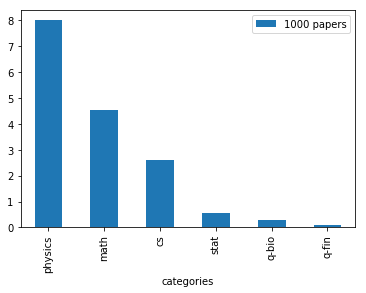

In [12]:
# plot the number of papers in each class
# the dataset is highly unbalanced, there's orders of magnitude between the most and the least frequent class

show_cats(sample_df)

# the world of quantative finance seems to be less keen on spending time writing papers than physicists

In [13]:
# get primary_categories (prim_cat) and text (title+abstract) only
# and safe those in 'bare data_frames'

def strip(df):
    df_2 = pd.concat([(df.title + " " + df.abstract).astype('str'),
                      df.prim_cat.astype('category')], axis=1)
    df_2.columns = ['text', 'label']
    return df_2

bare_dfs = {cat: strip(df) for (cat, df) in dfs.items()}

bare_sample_df = strip(sample_df)

In [14]:
# now we have for example

with pd.option_context('display.max_colwidth', 110):
    display(bare_sample_df[:3])

,text,label
0,The IBM 2016 Speaker Recognition System In this paper we describe the recent advancements made in the IB...,cs
1,The 2(2S+1)- Formalism and Its Connection with Other Descriptions In the framework of the Joos-Weinberg ...,math
2,Regression-based Intra-prediction for Image and Video Coding By utilizing previously known areas in an i...,cs


---

### One could also have a look at the papers' secondary categories of which there are almost 200 and there can be many such categories per paper. Maybe later...

In [15]:
# TODO side-project:
# classify by subcategories (first entries in the list in 'sec_cats' of each paper)

In [16]:
# one-hot-encode the 
ids_with_cats_ugly = full_df[['id', 'sec_cats']].set_index('id').sec_cats.str.split(expand=True).stack()
print(ids_with_cats_ugly[:10])

id_with_cats_df = pd.get_dummies(ids_with_cats_ugly).groupby(level=0).sum()
id_with_cats_df[:3]

id          
0704.0361  0      cs.IT
           1    math.IT
0704.0590  0      cs.IT
           1    math.IT
0704.0671  0      cs.IT
           1      cs.LG
           2    math.IT
0704.0805  0      cs.IT
           1    math.IT
0704.0858  0      cs.CR
dtype: object


,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
id,,,,,,,,,,,,,,,,,,,,,
0704.0189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
len(id_with_cats_df.columns)

168

In [18]:
# TODO take care of adap-org (nlin.AO), chao-dyn(nlin.CD), patt-sol (nlin.PS) etc.:

# Each category should be in the format 'general.specic' (e.g. 'astr-ph.CO') or just 'general' (e.g. 'astro-ph')
# but some of our columns are assigned to 'specific' in the spelled-out format (eg. chao-dyn instead of nlin.CD)
# See https://arxiv.org/ and http://arxitics.com/help/categories

# for column in id_with_cats_df:
#     print(column)

---

### Abstracts of scientific papers tend to be written in a formal style, not contain typos, no direct citations, little references, ...

In [19]:
# take a look at a few abstracts

import random
  
for _ in range(3):
    print(bare_sample_df.text.iloc[random.choice(range(len(bare_sample_df)))])
    print("---")

Chemical Abundance Analysis of Moving Group W11450 (Latham 1)   We present elemental abundances for all seven stars in Moving Group W11450
(Latham 1) to determine if they may be chemically related. These stars appear
to be both spatially and kinematically related, but no spectroscopic abundance
analysis exists in literature. Abundances for eight elements were derived via
equivalent width analyses of high resolution (R $\sim$60,000), high
signal-to-noise ratio ($\langle$SNR$\rangle\sim$100) spectra obtained with the
Otto Struve 2.1m telescope and Sandiford Echelle Spectrograph at McDonald
Observatory. The large star-to-star scatter in metallicity, -0.55 $\leq$ [Fe/H]
$\leq$ 0.06 dex ($\sigma$= 0.25), implies these stars were not produced from
the same chemically homogeneous molecular cloud, and are therefore not part of
a remnant or open cluster as previously proposed. Prior to this analysis, it
was suggested that two stars in the group, W11449 & W11450, are possible wide
binaries. The 

### One messy but informative kind of writing they have are LateX formulas.

In [20]:
bare_sample_df.text[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the $Q\\mathcal{V}$ operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n$Q$-invariant off-shell configurations in four-dimensional $\\mathcal{N}=2$\r\nsupergravity with $AdS_{2} \\times S^{2}$ boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin $\\mathcal{N}=2$ supergravity. We explain cancellations co

### Let's map those into a single 'word'

In [21]:
# mask all LaTeX with a single word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

class DeLaTeX(BaseEstimator, TransformerMixin):
    """
    Replace '\$(.+)?\$' with ' _LATEX_ '
    """

    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(r'\$(.+)?\$', ' _LATEX_ ')

In [22]:
delatex = DeLaTeX()
delatex.transform(bare_sample_df.text)[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the  _LATEX_  operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n _LATEX_ \r\nsupergravity with  _LATEX_  boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin  _LATEX_  supergravity. We explain cancellations concerning\r\n _LATEX_  supergravity that were observed in\r\narXiv:1111.1161. We also make com

---

## Let's build a simple untuned pipeline with a couple shallow classifiers
### We relay on the *class_weight* argument to account for the imbalance of our data

In [23]:
# Choose the data_frame

work_df = bare_sample_df

print(len(work_df))
work_df.dtypes

16128


text       object
label    category
dtype: object

In [24]:
from sklearn.model_selection import train_test_split

text_train, text_test, label_train, label_test = train_test_split(work_df.text, work_df.label, test_size=0.33, random_state=123)

In [25]:
# encode the labels, 'cs' -> 0, ..., 'stat' -> 5

from sklearn import preprocessing

label_e = preprocessing.LabelEncoder()
y_train = label_e.fit_transform(label_train)
y_test = label_e.transform(label_test)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'physics', 'q-bio', 'q-fin', 'stat']


### Let's first build the pipe and push the data trough step by step.

In [26]:
notex_text_train = delatex.fit_transform(text_train)
notex_text_test = delatex.transform(text_test)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

count_v = CountVectorizer(strip_accents='unicode')
word_counts_train = count_v.fit_transform(notex_text_train)
word_counts_test = count_v.transform(notex_text_test)
word_counts_train.shape

(10805, 37937)

In [31]:
# Why is there fewer rows? Were they empty?

In [32]:
# take a look at the most frequent words (after using the 'max_df' above)

sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(sum_word_counts_train[0, i], word) for word, i in count_v.vocabulary_.items()],reverse=True)[:15]

# The '_latex_' word of ours id dangerously high.
# Yet I would still hope that it is underrepresented in quantitative biology or quantitative finance
# We'll settle on max_df=0.8
# 
# Maybe we should have balanced the classes...

[(113420, 'the'),
 (71769, 'of'),
 (39808, 'and'),
 (35847, 'in'),
 (30939, 'to'),
 (23502, 'we'),
 (21230, 'is'),
 (20436, 'for'),
 (15495, 'that'),
 (14938, '_latex_'),
 (14689, 'with'),
 (12535, 'on'),
 (11021, 'this'),
 (10733, 'are'),
 (10459, 'by')]

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

def build_arXivMeta_clf(model):
    pipe = []
    pipe.append(( 'delatex', DeLaTeX() ))
    pipe.append(( 'count_v', CountVectorizer(strip_accents='unicode', min_df = 2, max_df = 0.8)  ))
    pipe.append(( 'tfidf_t', TfidfTransformer(use_idf=False)  ))
    pipe.append(( 'sgd_clf', model  ))

    return Pipeline(pipe)

In [37]:
# our first model, an linear SVMM with stochastic gradient descent

from sklearn.linear_model import SGDClassifier

arXivMeta_clf_1 = build_arXivMeta_clf(
    SGDClassifier(loss='hinge', class_weight="balanced", n_jobs=-1, max_iter=1000, tol=1e-3)
)
arXivMeta_clf_1.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto..._state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

### Ok, let's just have some fun first:

In [38]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms  This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
We offer a novel less intuitive proof of $\limit_{x\to 0} x = 0$,
""",
"""
infllation resources market stock bonds derivatives
""",
"""
distribution Bayesian p value marginalization Monte Carlo
"""
])


label_e.inverse_transform(arXivMeta_clf_1.predict(random_abstracts))

array(['cs', 'physics', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

In [39]:
# looks promising

### Check the multilabel classification accuracy

In [40]:
from sklearn import metrics

def show_metrics(clf):
    predicted_y_test = clf.predict(text_test)
    print(metrics.classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
    print(metrics.confusion_matrix(y_test, predicted_y_test))

In [41]:
show_metrics(arXivMeta_clf_1)

              precision    recall  f1-score   support

          cs       0.69      0.71      0.70       894
        math       0.80      0.74      0.77      1510
     physics       0.93      0.90      0.91      2633
       q-bio       0.42      0.55      0.48        80
       q-fin       0.31      0.57      0.40        30
        stat       0.33      0.59      0.42       176

   micro avg       0.80      0.80      0.80      5323
   macro avg       0.58      0.67      0.61      5323
weighted avg       0.82      0.80      0.81      5323

[[ 633  107   37   12    8   97]
 [ 179 1115  121   10   16   69]
 [  66  143 2362   29    7   26]
 [  10    4   11   44    1   10]
 [   1    6    1    0   17    5]
 [  30   26    3    9    5  103]]


In [42]:
# TODO: understand what the above values are

In [43]:
# try a random forest

from sklearn.ensemble import RandomForestClassifier

arXivMeta_clf_2 = build_arXivMeta_clf(
    RandomForestClassifier(class_weight = 'balanced', n_estimators=100, max_depth=10, criterion='entropy', random_state=123)
)
arXivMeta_clf_2.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto...tors=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False))])

In [44]:
show_metrics(arXivMeta_clf_2)

              precision    recall  f1-score   support

          cs       0.61      0.59      0.60       894
        math       0.67      0.74      0.70      1510
     physics       0.89      0.81      0.85      2633
       q-bio       0.31      0.41      0.35        80
       q-fin       0.62      0.43      0.51        30
        stat       0.33      0.48      0.40       176

   micro avg       0.74      0.74      0.74      5323
   macro avg       0.57      0.58      0.57      5323
weighted avg       0.75      0.74      0.74      5323

[[ 530  198   64   15    3   84]
 [ 176 1119  156    7    5   47]
 [  96  318 2145   45    0   29]
 [  15    3   22   33    0    7]
 [   4    9    2    0   13    2]
 [  46   30    8    7    0   85]]


In [ ]:
# TODO:

# add LogisticRegression, RidgeClassifier with the 'class_weight=balanced' argument

# make a prettier confusion matrix with a heat_map 

# grid search with cross validation

# try Hash Vectorizer instead of CountVectorizer
# balance the classes by up-/down-sampling and use other models (MultiNomial Naive Bayes)
# out-of-core learning ?

# see how accuracy scales with data volume (we have 800 MB to go around)

# unsupervised learning:
# LDA
# clustering
# visualization: t-SNE ?

# deep learning ?

# multilabel learning (with the secondary classes) ?